# 探索的データ解析


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
train = train.replace("male",0).replace("female",1)

In [2]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


## * Seaborn を使って相関性をheatmapに

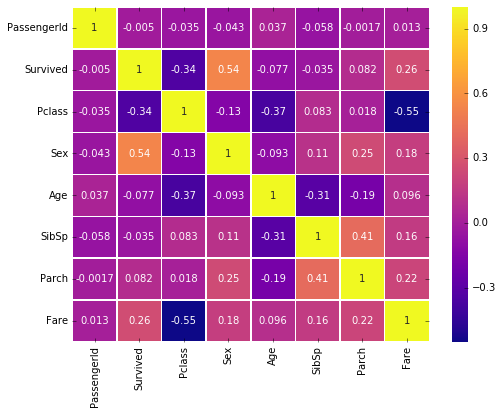

In [3]:
plt.figure(figsize=(8,6)) #heatmap size
sns.heatmap(train.corr(), annot=True, cmap="plasma", linewidths=.5)
#annot: 値を表示するかどうか, linewidths: しきい線

## [memo]
相関が大きい順に
Sex > Age >Pclass > Fare

FareとPclassの相関性も高い→fareも特徴量として良いかも


## * 欠損値の確認

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## [memo]
* 687ものCabinのデータが欠損しているが、そもそもCabinの情報は生死に影響を与えているのか?
-> 相関性が低ければ除外してもいい？

## * 家族の有無、家族の多さと生死の相関性を調べる
### 新たなカラム[FamilySize]と[IsAlone]を作成

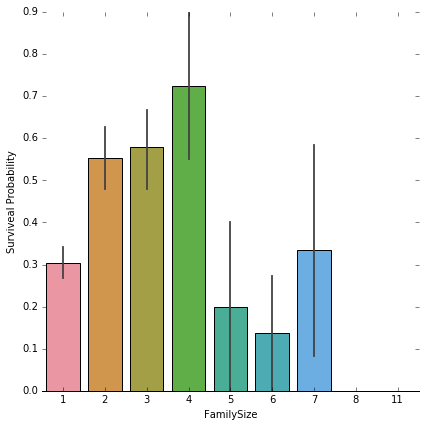

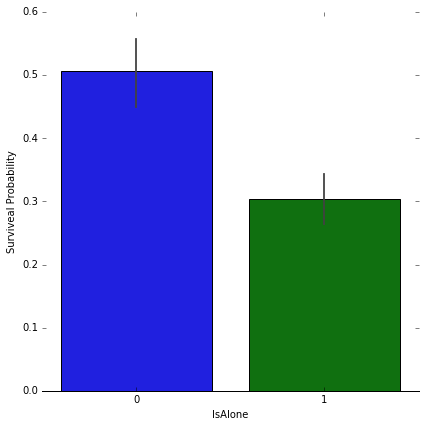

In [5]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
for train in [train]:
    train['IsAlone'] = 0
    train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
    
#FamiliySizeとSurvived
g = sns.catplot(x="FamilySize", y="Survived", height=6, data=train, kind="bar")
g.despine(left=True)
g = g.set_ylabels("Surviveal Probability")

#IsAloneとSurvived
g2 = sns.catplot(x="IsAlone", y="Survived", height=6, data=train, kind="bar")
g2.despine(left=True)
g2 = g2.set_ylabels("Surviveal Probability")

### [memo]
* 2~4人家族（または同乗者）が生存率が高く5人以降は生存率が低い
* 7人家族は1人で乗った人と同じくらいの生存率でほぼ7割が死亡していることがわかる。
* 8人、11人家族は全滅
* 1人で乗船した人はそうでない場合と比べて二割ほど生存率が低い

→1人で乗船したかもしくは5人以上の家族は生存に不利

### * 敬称から年齢を推定できる？

正規表現を使って敬称別のカウントを表示

In [21]:
age_name = train[["Age","Name"]]
na_omit_age_name = age_name.dropna()
na_omit_age_name.head()

,Age,Name
0,22.0,"Braund, Mr. Owen Harris"
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,26.0,"Heikkinen, Miss. Laina"
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,35.0,"Allen, Mr. William Henry"


In [22]:
print(train["Name"].str.extract('([A-Za-z]+\.)').value_counts(), "\n")
print(na_omit_age_name["Name"].str.extract('([A-Za-z]+\.)').value_counts(), "\n")

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Ms.            1
Jonkheer.      1
Mme.           1
Lady.          1
Don.           1
Capt.          1
Countess.      1
Sir.           1
Name: Name, dtype: int64 

Mr.          398
Miss.        146
Mrs.         108
Master.       36
Dr.            6
Rev.           6
Mlle.          2
Col.           2
Major.         2
Ms.            1
Jonkheer.      1
Mme.           1
Lady.          1
Don.           1
Capt.          1
Countess.      1
Sir.           1
Name: Name, dtype: int64 



/Users/kotaroyamazaki/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/Users/kotaroyamazaki/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


上位6件について年齢の平均値を算出してみる

In [30]:
import numpy as np
honorific = ["Mr.", "Miss", "Mrs.", "Master", "Dr.", "Rev"]
honorific_age = [[],[],[],[],[],[]]
for i in range(0, len(na_omit_age_name)):
    if train['Name'][i].lower().find('mr.') > -1 :
        if  train['Age'][i] > -1:
            honorific_age[0].append(train['Age'][i])
        pass
    if train['Name'][i].lower().find('miss') > -1:
        if  train['Age'][i] > -1:
            honorific_age[1].append(train['Age'][i])
        pass
    if train['Name'][i].lower().find('mrs') > -1:
        if  train['Age'][i] > -1:
            honorific_age[2].append(train['Age'][i])
        pass
    if train['Name'][i].lower().find('master.') > -1:
        if  train['Age'][i] > -1:
            honorific_age[3].append(train['Age'][i])
        pass
    if train['Name'][i].lower().find('dr.') > -1:
        if  train['Age'][i] > -1:
            honorific_age[4].append(train['Age'][i])
        pass
    if train['Name'][i].lower().find('rev.') > -1:
        if  train['Age'][i] > -1:
            honorific_age[5].append(train['Age'][i])
        pass
print("[Median age]")
median = []
mean = []
for i in range(0,len(honorific_age)):
    median.append(np.median(honorific_age[i]))
    print(honorific[i],":",median[i])
    
print("\n[Average age]")
for i in range(0,len(honorific_age)):
    mean.append(sum(honorific_age[i])/len(honorific_age[i]))
    print(honorific[i],":", mean[i])

[Median age]
Mr. : 30.0
Miss : 21.0
Mrs. : 34.0
Master : 3.5
Dr. : 44.0
Rev : 52.5

[Average age]
Mr. : 33.021875
Miss : 22.0203252033
Mrs. : 34.6547619048
Master : 4.82291666667
Dr. : 40.6
Rev : 51.0


([<matplotlib.axis.XTick at 0x1271d6da0>,
 <a list of 6 Text xticklabel objects>)

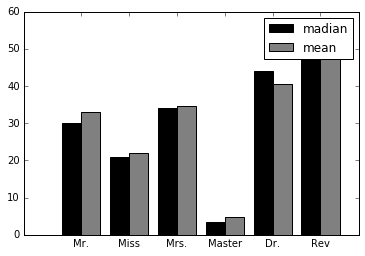

In [31]:
x = np.array([1,2,3,4,5,6])
bar_width = 0.4
plt.bar(x,median, color = "black", label = "madian",width = bar_width,align = "center")
plt.bar(x + bar_width, mean, color = "gray", label = "mean",width = bar_width, align ="center")
plt.legend()
plt.xticks(x + bar_width/2, honorific)


### [memo]
* 敬称から年齢の欠損値を埋める方法は有効性がありそう!

<コードについて>
* 書き方がわからずナイーブな書き方になってしまった。欠損値を判定するisnull()を条件式で使えなかったのはなんでだろう…
* 配列の初期化もダサいと思います
* グラフの出力形式は適切か？

### その他の年齢層を推定

In [32]:
for i in range(0,len(na_omit_age_name)):
    name = train['Name'][i].lower()
    if name.find('mr.') == -1 and name.find('mrs.') == -1 and name.find("master") == -1 and name.find('dr.') == -1 and name.find('miss.') == -1 and name.find('rev.') == -1:
        print(train["Name"][i],": ",train["Age"][i])

Uruchurtu, Don. Manuel E :  40.0
Aubart, Mme. Leontine Pauline :  24.0
Reynaldo, Ms. Encarnacion :  28.0
Peuchen, Major. Arthur Godfrey :  52.0
Butt, Major. Archibald Willingham :  45.0
Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan") :  48.0
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan") :  49.0
Sagesser, Mlle. Emma :  24.0
Simonius-Blumer, Col. Oberst Alfons :  56.0
Weir, Col. John :  60.0
Mayne, Mlle. Berthe Antonine ("Mrs de Villiers") :  24.0


* Mile: 24
* Mme: 24
* Ms: 28
* Don: 40
* Lady: 48
* Sir: 49
* Major: 52
* Col: 56,60

findの複数条件検索がわからなかった

In [33]:
honorific_dict ={
    "Mr.": 0,
    "Miss.": 1,
    "Mme.": 1,
    "Mlle.": 1,
    "Master.": 2,
    "Mrs.": 3,
    "Ms.": 3,
    "Dr.": 4,
    "Rev.": 4,
    "Capt.": 4,
    "Col.": 4,
    "Major.": 4,
    "Don.": 5,
    "Jonkheer.": 5,
    "Sir.": 5,
    "Dona.": 5,
    "Countess.": 5,
    "Lady.": 5
} 

train["Honorific"] = train["Name"].str.extract('([A-Za-z]+\.)').map(honorific_dict)
test["Honorific"] = train["Name"].str.extract('([A-Za-z]+\.)').map(honorific_dict)
train.head()

/Users/kotaroyamazaki/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:22: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/Users/kotaroyamazaki/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Honorific
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,1,0


In [34]:
age_insert_list = median
age_byHono = []
for row in range(0,len(train)):
    if train["Age"][row] > 0:
        age_byHono.append(train["Age"][row])
        pass
    else:
         age_byHono.append(train["Honorific"][row])
train["Age_by_Honorific"] = age_byHono

In [35]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Honorific,Age_by_Honorific
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,0,3,38.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,0,3,35.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,1,0,35.0
